In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import numpy as np
import pandas as pd

x = np.linspace(0, 10, 1000)
y = np.sin(x) + 0.1 * np.random.randn(1000)
pd.DataFrame({"x": x, "y": y}).to_csv("/content/drive/MyDrive/SDGOptimizations/test_data.csv", index=False)

In [35]:
dataframe = pd.read_csv("/content/drive/MyDrive/SDGOptimizations/test_data.csv")
dataframe.head()

,x,y
0,0.00000,0.061278
1,0.01001,-0.070645
2,0.02002,0.105380
3,0.03003,0.011771
4,0.04004,-0.006785


In [36]:
x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

In [172]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.SiLU(),

    torch.nn.Linear(256, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.SiLU(),

    torch.nn.Linear(128, 64),
    torch.nn.Dropout(0.2),
    torch.nn.SiLU(),

    torch.nn.Linear(64, 1),
    torch.nn.Tanh()
)

In [173]:
for layer in model:
    if isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        torch.nn.init.zeros_(layer.bias)

In [174]:
import numpy as np
import torch
import torch.optim as optim
import yaml
from pathlib import Path
import os

with open("/content/drive/MyDrive/SDGOptimizations/config.yaml") as f:
    config = yaml.safe_load(f)

In [175]:
lr = config["training"]["learning_rate"]
print(f"Using optimizer: {config['training']['optimizer']}")

Using optimizer: Adam


In [176]:
model = torch.nn.Sequential(torch.nn.Linear(1, 1))
criterion = torch.nn.MSELoss()

In [177]:
model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [179]:
if config["training"]["optimizer"] == "SGD":
    optimizer = optim.SGD(
        model.parameters(),
        lr=float(config["training"]["learning_rate"]),
        momentum=0.9,
        weight_decay=0.05
    )
elif config["training"]["optimizer"] == "Adam":
    optimizer = optim.Adam(
        model.parameters(),
        lr=float(config["training"]["learning_rate"]),
        eps=float(config["adaptive"]["epsilon"]),
        weight_decay=0.05
    )

In [180]:
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=0.0001,
    max_lr=0.01,
    step_size_up=500,
    cycle_momentum=False
)

In [181]:
print(f"Learning rate type: {type(config['training']['learning_rate'])}")
print(f"beta1 type: {type(config['adaptive']['beta1'])}")

Learning rate type: <class 'float'>
beta1 type: <class 'float'>


In [182]:
print("Config values:")
print(f"lr: {config['training']['learning_rate']} (type: {type(config['training']['learning_rate'])})")
print(f"beta1: {config['adaptive']['beta1']} (type: {type(config['adaptive']['beta1'])})")
print(f"beta2: {config['adaptive']['beta2']} (type: {type(config['adaptive']['beta2'])})")
print(f"epsilon: {config['adaptive']['epsilon']} (type: {type(config['adaptive']['epsilon'])})")
print(f"epochs: {config['training']['epochs']} (type: {type(config['training']['epochs'])})")
print(f"batch_size: {config['training']['batch_size']} (type: {type(config['training']['batch_size'])})")

Config values:
lr: 0.01 (type: <class 'float'>)
beta1: 0.9 (type: <class 'float'>)
beta2: 0.999 (type: <class 'float'>)
epsilon: 1e-8 (type: <class 'str'>)
epochs: 250 (type: <class 'int'>)
batch_size: 32 (type: <class 'int'>)


In [183]:
x = torch.tensor(dataframe["x"].values, dtype=torch.float32).unsqueeze(1)
y = torch.tensor(dataframe["y"].values, dtype=torch.float32).unsqueeze(1)

In [184]:
print(x.shape)
print(y.shape)

torch.Size([1000, 1])
torch.Size([1000, 1])


In [185]:
print(x.dtype)

torch.float32


In [186]:
epsilon = float(config['adaptive']['epsilon'])
print(epsilon)

1e-08


In [187]:
output_dir = "/content/drive/MyDrive/SDGOptimizations"
grad_dir = os.path.join(output_dir, "gradients")
os.makedirs(grad_dir, exist_ok=True)

losses, grads = [], []

for epoch in range(config['training']['epochs']):
    permutation = torch.randperm(len(x))
    x = x[permutation]
    y = y[permutation]

    for i in range(0, len(x), config['training']['batch_size']):
        batch_x = x[i:i+config['training']['batch_size']]
        batch_y = y[i:i+config['training']['batch_size']]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()

        grads.append([p.grad.detach().cpu().numpy().copy() for p in model.parameters()])
        losses.append(loss.item())
        optimizer.step()
        scheduler.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            train_loss = criterion(model(x), y)
            print(f'Epoch {epoch:3d} | Loss: {train_loss:.4f} | LR: {optimizer.param_groups[0]["lr"]:.2e}')



Epoch   0 | Loss: 7.4577 | LR: 7.34e-04
Epoch  10 | Loss: 0.5349 | LR: 7.07e-03
Epoch  20 | Loss: 0.4783 | LR: 6.59e-03
Epoch  30 | Loss: 0.4662 | LR: 2.58e-04
Epoch  40 | Loss: 0.4586 | LR: 6.28e-03
Epoch  50 | Loss: 0.4517 | LR: 7.39e-03
Epoch  60 | Loss: 0.4510 | LR: 1.05e-03
Epoch  70 | Loss: 0.4509 | LR: 5.49e-03
Epoch  80 | Loss: 0.4507 | LR: 8.18e-03
Epoch  90 | Loss: 0.4507 | LR: 1.84e-03
Epoch 100 | Loss: 0.4510 | LR: 4.69e-03
Epoch 110 | Loss: 0.4509 | LR: 8.97e-03
Epoch 120 | Loss: 0.4506 | LR: 2.63e-03
Epoch 130 | Loss: 0.4519 | LR: 3.90e-03
Epoch 140 | Loss: 0.4508 | LR: 9.76e-03
Epoch 150 | Loss: 0.4505 | LR: 3.43e-03
Epoch 160 | Loss: 0.4506 | LR: 3.11e-03
Epoch 170 | Loss: 0.4523 | LR: 9.45e-03
Epoch 180 | Loss: 0.4506 | LR: 4.22e-03
Epoch 190 | Loss: 0.4512 | LR: 2.32e-03
Epoch 200 | Loss: 0.4567 | LR: 8.65e-03
Epoch 210 | Loss: 0.4516 | LR: 5.01e-03
Epoch 220 | Loss: 0.4507 | LR: 1.53e-03
Epoch 230 | Loss: 0.4593 | LR: 7.86e-03
Epoch 240 | Loss: 0.4525 | LR: 5.80e-03


In [188]:
try:
    np.save(os.path.join(output_dir, "losses.npy"), np.array(losses))
    np.save(os.path.join(grad_dir, "grads.npy"), np.array(grads, dtype=object))
    torch.save(model.state_dict(), os.path.join(output_dir, "final_model.pkl"))
    print(f"Results successfully saved to {output_dir}")
except Exception as e:
    print(f"Error saving results: {str(e)}")

Results successfully saved to /content/drive/MyDrive/SDGOptimizations


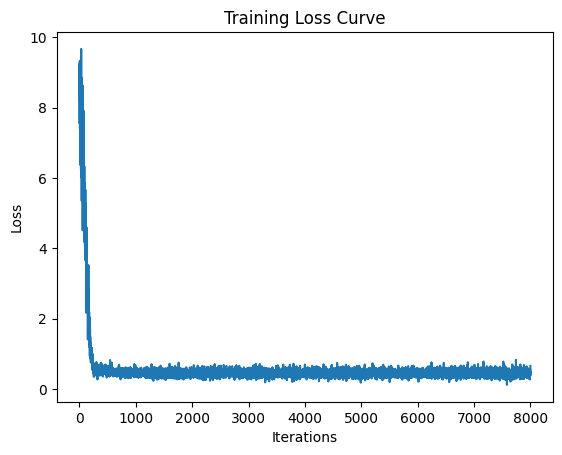

In [189]:
import matplotlib.pyplot as plt
losses = np.load("/content/drive/MyDrive/SDGOptimizations/losses.npy")
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig(f"{output_dir}/loss_curve.png")